In [77]:
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils

import torchvision
import torch.nn as nn 
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import torch 
from typing import Dict, Any, List
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import collections

In [78]:
#-- data 
images_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/DOTA_dataset/dota1_ms_train/images"
anno_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/DOTA_dataset/dota1_ms_train/annfiles"

# VOC class names

#---------------------------------
#-- args operation
EXEC_VER = 7 # zero means test 
DDP = False
TASK = "Object_Detection"
#-- args data
IMAGE_SIZE = 600
CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]

dataset_ = RS_dataset.Detection_Dataset_v2(images_path, anno_path, CLASSES, image_size=IMAGE_SIZE, normalizing=True)

In [79]:
ra = np.random.randint(0,1000)
#ra = 18
a,b,c = dataset_.__getitem__(ra)

tensor


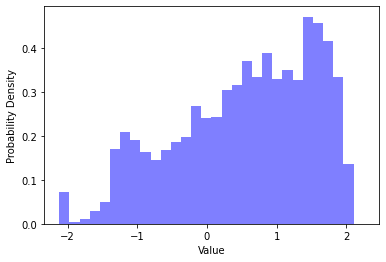

In [80]:
if str(type(a)) =="<class 'torch.Tensor'>":
    print("tensor")
    r_channel = a[0,:].flatten().numpy()
    g_channel = a[1,:].flatten().numpy()
    b_channel = a[2,:].flatten().numpy()
elif str(type(a)) == "<class 'numpy.ndarray'>":
    print("numpy")
    r_channel = a[0,:].flatten()
    g_channel = a[1,:].flatten()
    b_channel = a[2,:].flatten()
    
plt.hist(r_channel, bins=30, density=True, alpha=0.5, color='b')  # Density=True for normalized histogramplt.title('Histogram of Random Data')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.show()

# zero-centerized 일 때 작동을 안해.. ? 

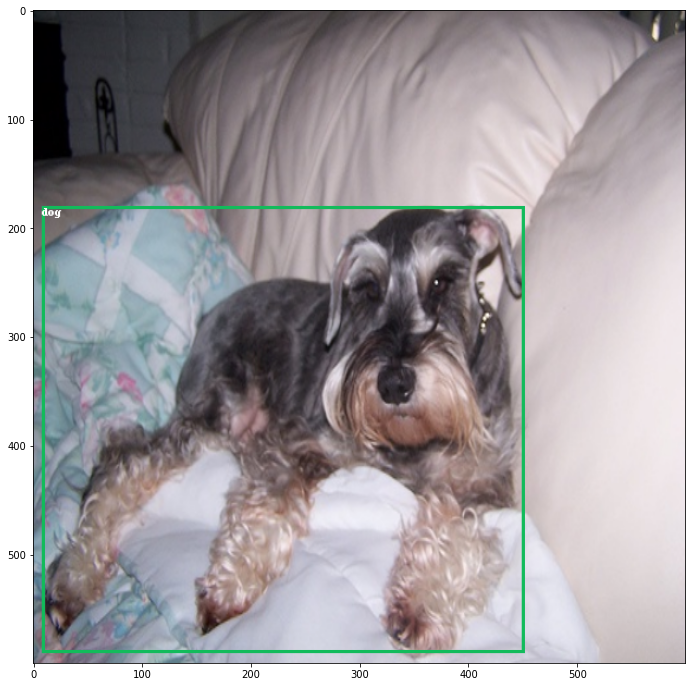

In [81]:
RS_utils.show_box(a, b,c, CLASSES, denormal=True)

tensor


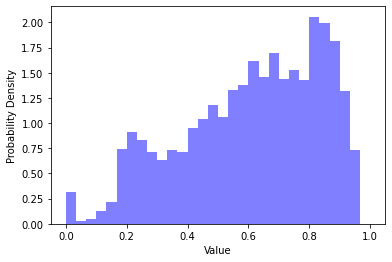

In [82]:
if len(a.shape) == 4:
    a = a[0,:]

if str(type(a)) =="<class 'torch.Tensor'>":
    print("tensor")
    r_channel = a[0,:].flatten().numpy()
    g_channel = a[1,:].flatten().numpy()
    b_channel = a[2,:].flatten().numpy()
elif str(type(a)) == "<class 'numpy.ndarray'>":
    print("numpy")
    r_channel = a[0,:].flatten()
    g_channel = a[1,:].flatten()
    b_channel = a[2,:].flatten()
    
plt.hist(r_channel, bins=30, density=True, alpha=0.5, color='b')  # Density=True for normalized histogramplt.title('Histogram of Random Data')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.show()

# de-normal 이후에, mean value 0.5 로 shift 되는데, 그때부터는 다시 작동? 하네,, mu 256 일때 not working, zero-center 일때 not working 

In [83]:
model = RS_models.torchvision_fasterrcnn(weights_='COCO_V1')

In [91]:
model

#   (transform): GeneralizedRCNNTransform(
#       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#       Resize(min_size=(800,), max_size=1333, mode='bilinear')
#   ) 이 같이 포함되어 있음 ! 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [95]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [85]:
if str(type(a)) == "<class 'numpy.ndarray'>":
    print("numpy")
    a = torch.from_numpy(a)
    a = a.permute(2,0,1)
    a = a.float()
    
a = a.unsqueeze(0)
print(a.shape)
model.eval()
output = model(a)

torch.Size([1, 3, 600, 600])


In [86]:
output

[{'boxes': tensor([[ 15.1634, 183.5829, 463.5203, 581.0156],
          [  0.0000,   2.4959, 600.0000, 600.0000],
          [ 61.1933,   0.0000, 599.8325, 552.1650],
          [  0.0000, 296.0424, 565.4783, 600.0000],
          [  0.0000, 104.3874, 233.8149, 600.0000],
          [319.3564,   0.0000, 584.0740, 594.9512],
          [ 45.8088,   2.5454, 599.5146, 287.5350],
          [106.0423,  35.1273, 558.3506, 575.4496],
          [ 19.6094,   0.0000, 600.0000, 294.3743],
          [215.6557, 179.9818, 511.4494, 598.6371],
          [  1.5209, 184.7366, 447.6743, 589.5687],
          [  1.6542, 109.6135, 226.0889, 598.7967]], grad_fn=<StackBackward0>),
  'labels': tensor([18, 65, 63, 65, 65, 65,  1,  1, 65, 18,  1, 63]),
  'scores': tensor([0.9902, 0.6687, 0.4889, 0.4014, 0.2355, 0.1516, 0.1371, 0.1065, 0.1025,
          0.0527, 0.0525, 0.0510], grad_fn=<IndexBackward0>)}]

In [87]:
output[0].keys()

dict_keys(['boxes', 'labels', 'scores'])

In [88]:
output[0]['scores']

tensor([0.9902, 0.6687, 0.4889, 0.4014, 0.2355, 0.1516, 0.1371, 0.1065, 0.1025,
        0.0527, 0.0525, 0.0510], grad_fn=<IndexBackward0>)

batch


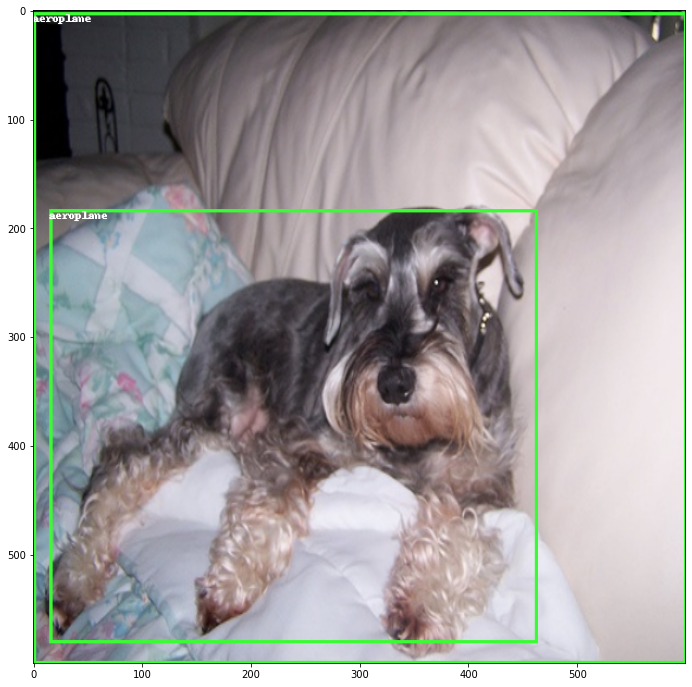

In [89]:
bboxes = output[0]['boxes'].detach().numpy()
scores = output[0]['scores']

bboxes = bboxes[0:2]
scores = scores[0:2]

RS_utils.show_box(a, bboxes, scores, classes = CLASSES , denormal=False)

batch


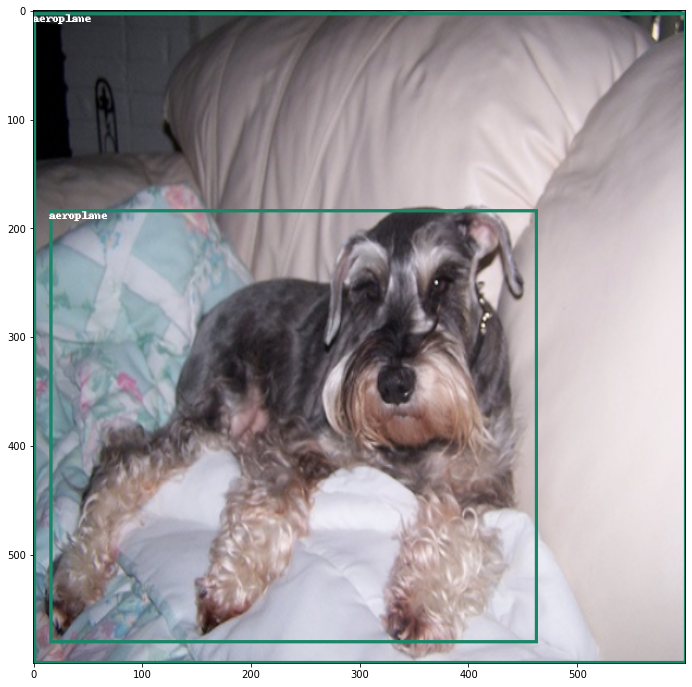

In [90]:
RS_utils.show_box(a, bboxes, scores, classes = CLASSES , denormal=False)